Het voorspellen van de bondprijs alleen op basis van historische waarde van de bond is waarschijnlijk nooit erg succesvol. Voor een betere voorspelling zullen we 'leading indicatoren' moeten hebben. Indicatoren die iets zeggen waar de markt naar toe gaat.

Op basis van de literatuurstudie en een selectie van welke data beschikbaar was voor dit onderzoek, zijn de volgende features geselecteerd:
- Remaining Duration
- Theoretical Bond Prices
- Inflation curve
- Referentie bond (10 jaars bonds, met zelfde maturity)
- Term Spread
- Bid Offer Spread

In [3]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons
    %cd BondTrading

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "..")



import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler

from src.data import make_dataset, join_data, window, split
from src.models import base_model, evaluate, hyper
from src.visualization import visualize
from src.features import build_features

In [5]:
df_bp = make_dataset.read_pkl('bp', path = Path("data/processed/"), colab = IS_COLAB) 
isin = "NL0011220108" # 10 Years NL Bond, maturity 2025 0.25% coupon
df_isin = df_bp[df_bp['reference_identifier'] == isin]

2022-01-26 23:26:09.136 | INFO     | src.data.make_dataset:read_pkl:418 - Load preprocessed bp data


Door de te verwachten kasstromen te projecteren met de rente van het contract, en te verdisconteren tegen een passend rentepercentage kan een voorspelling worden gemaakt van de 'theoretische' marktwaarde van de bond. De markt kan tijdelijk de bond door vraag en aanbod hoger of lager prijzen dan deze intrinsieke waarde, maar de verwachting is dat de prijs van de bond uiteindelijk toch niet lang zal afwijken van de intrinsieke waarde.

In [6]:
# Add theoretically calculated bond price

df_yield = make_dataset.read_pkl('yield', path = Path("data/processed/"), colab = IS_COLAB)

df_isin_ytm = join_data.yield_to_maturity(df_isin, df_yield)
df_isin_ytm = build_features.add_estimated_bond_price(df_isin_ytm)


2022-01-26 23:26:09.670 | INFO     | src.data.make_dataset:read_pkl:418 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt'>

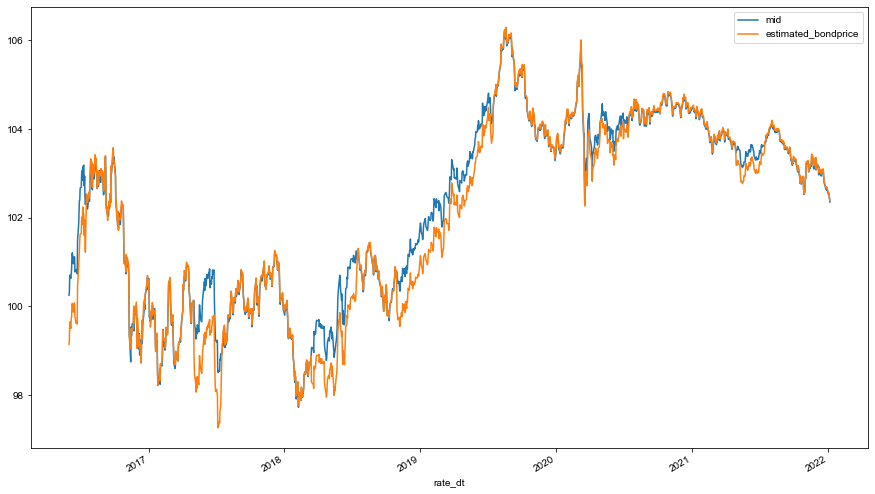

In [7]:
df_isin_ytm.plot(x = 'rate_dt',y = ['mid','estimated_bondprice'], figsize = (15,9))

In [9]:
# Add Term Spread and Bid-Offer spread
df_bpy = join_data.join_yield(df_isin_ytm, df_yield)
df_bpy = build_features.add_term_spread(df_bpy)
df_bpy = build_features.add_bid_offer_spread(df_bpy)

2022-01-26 23:26:11.752 | INFO     | src.features.build_features:add_term_spread:64 - Add term spread...
2022-01-26 23:26:11.755 | INFO     | src.features.build_features:add_bid_offer_spread:75 - Add bid offer spread...


Qua inflatiegegevens beschikken we niet over dagelijke gegevens van de Nederlandse inflatie. Duitsland wordt hier als proxi gebruikt voor de inflatiecijfers van Nederland.

In [10]:
# Add inflation
df_inflation = make_dataset.read_pkl('inflation', path = Path("data/processed/"), colab = IS_COLAB) 
df_bpyi = join_data.join_10y_inflation(df_bpy, df_inflation, country = 'Germany')

2022-01-26 23:26:12.098 | INFO     | src.data.make_dataset:read_pkl:418 - Load preprocessed inflation data


In [11]:
# reference bonds
df_mature_2025 = df_bp.loc[( df_bp['mature_dt'].dt.year == 2025 )]
filter =    ( df_mature_2025['coupon'] > 0 ) & \
            ( df_mature_2025['rate_dt'] > '1-jun-2016' ) & \
            ( df_mature_2025['country'] != 'Netherlands' )            

df_mature_2025 = df_mature_2025.loc[filter]
df_r = df_mature_2025.pivot(index = 'rate_dt', columns = 'reference_identifier', values = 'mid').dropna(axis = 'columns')


In [13]:
df_bpyir = df_bpyi.merge(df_r, on = 'rate_dt', how = 'inner' )
df_bpyir

,reference_identifier,rate_dt,ccy,mid,lastday,country,bond_ext_name,issue_dt,first_coupon_date,mature_dt,...,7 YEARS,8 YEARS,9 YEARS,AT0000A1FAP5,BE0000334434,DE0001102374,DE0001102382,FR0012517027,FR0012938116,IT0005090318
0,NL0011220108,2016-06-02,EUR,100.319,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.16000,1.27500,1.39250,108.171,103.858,104.508,108.670,101.550,105.616,101.619
1,NL0011220108,2016-06-03,EUR,100.702,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.15000,1.26500,1.38250,108.562,104.220,104.903,109.103,101.916,106.036,102.073
2,NL0011220108,2016-06-06,EUR,100.632,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.15500,1.26750,1.39250,108.459,104.109,104.914,109.124,101.776,105.883,101.598
3,NL0011220108,2016-06-07,EUR,100.751,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.15500,1.27000,1.39250,108.661,104.349,105.067,109.298,101.984,106.132,102.078
4,NL0011220108,2016-06-08,EUR,100.841,2016-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,1.16750,1.27250,1.39500,108.756,104.364,105.101,109.335,102.001,106.133,102.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,NL0011220108,2021-12-17,EUR,103.034,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.21625,2.20625,2.20375,106.888,104.943,103.912,106.212,103.648,106.057,105.311
1409,NL0011220108,2021-12-20,EUR,103.070,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.21875,2.21000,2.20875,106.951,104.978,103.965,106.265,103.703,106.112,105.329
1410,NL0011220108,2021-12-21,EUR,102.951,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.28125,2.27625,2.27500,106.835,104.885,103.884,106.149,103.602,105.977,105.216
1411,NL0011220108,2021-12-22,EUR,102.820,2021-12-31,Netherlands,NEDERLAND 0.25% 15-2025,2015-03-26,2015-07-15,2025-07-15,...,2.35250,2.34750,2.34375,106.691,104.791,103.789,106.024,103.523,105.838,105.047


In [14]:

df_bpyi = df_bpyi[['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10','10 YEARS']]
df_bpyi.columns = ['rate_dt','mid','estimated_bondprice','term_spread','bid_offer_spread_10y','inflation_10y']
df_bpyi = df_bpyi.set_index('rate_dt')
df_bpyi = df_bpyi.sort_index()

De dataset wordt weer gesplit in 70% trainingsdata en 30% test data. Dit om het model vergelijkbaar te houden met de modellen die alleen op het signaal getrained waren.

In [15]:
df_train, df_test = split.split_data(df_bpyi, 0.7,['mid'])

scaler = MinMaxScaler()
df_train[df_train.columns] = scaler.fit_transform(df_train[df_train.columns])
df_test[df_test.columns] = scaler.transform(df_test[df_test.columns])


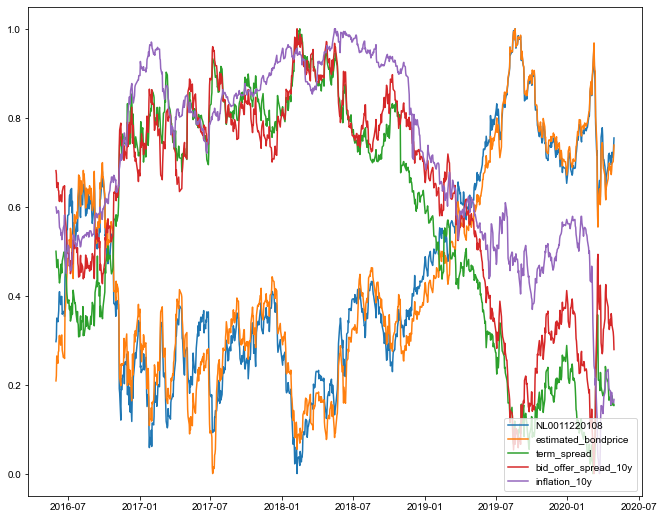

In [16]:
plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(df_train.iloc[:,0], label=isin)
line2, = plt.plot(df_train.iloc[:,1], label="estimated_bondprice")
line3, = plt.plot(df_train.iloc[:,2], label="term_spread")
line4, = plt.plot(df_train.iloc[:,3], label="bid_offer_spread_10y")
line4, = plt.plot(df_train.iloc[:,4], label="inflation_10y")
leg = plt.legend(loc='lower right')


De correlatie tussen deze items is zeer opvallend. Ik zie nog niet hoe dit mogelijk is. De spread tussen bid en ask prijzen en de spread tussen 2 years en 10 years bonds volgen bijna naadloos een zelfde trend als de ontwikkeling van de marktwaarde van de bond. Wanneer we deze spreads even omdraaien wordt dit nog duidelijker. Een mogelijke verklaring hiervoor zou kunnen zijn dat deze indicatoren worden gebruikt door de algo traders in hun modellen en zodoende feitenlijk de bondprijzen bepalen. In de literatuur heb ik hier geen aanwijzingen voor gevonden.

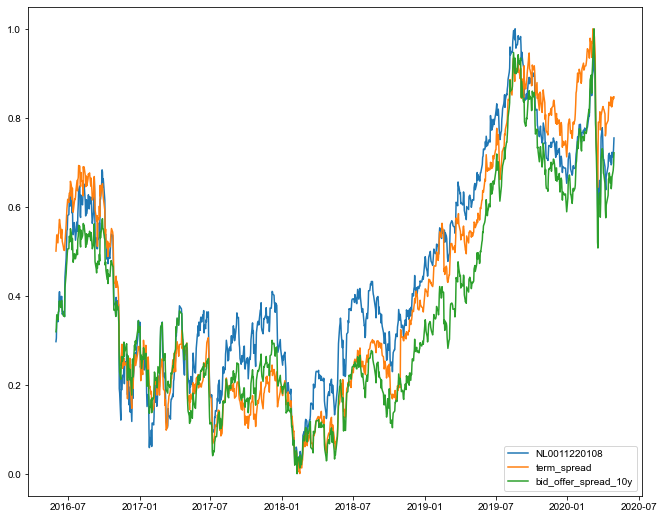

In [17]:
plt.rcParams["figure.figsize"] = [11, 9]
line1, = plt.plot(df_train.iloc[:,0], label=isin)
line3, = plt.plot(df_train.iloc[:,2] * -1 + 1, label="term_spread")
line4, = plt.plot(df_train.iloc[:,3] * -1 + 1, label="bid_offer_spread_10y")
leg = plt.legend(loc='lower right')

In [18]:
# Create a windowed dataset from the data

window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset(df_train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset(df_test, window_size, batch_size, shuffle_buffer, horizon=horizon)

2022-01-26 23:26:15.653 | INFO     | src.models.window:windowed_dataset:14 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10
2022-01-26 23:26:16.668 | INFO     | src.models.window:windowed_dataset:14 - Split windowed dataset window_size = 32, batch_size =  32, shuffle_buffer =  2, horizon =  10


In [19]:
y, yhat = base_model.naivepredict(df_train.iloc[:, 0].values)
norm = evaluate.mae(y, yhat)
evaluate.mae(y, yhat), evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.01771326338598396, 0.0005914568464814363, 0.9994436519273704)

In [20]:
# Mean Absolute Error - for horizon
norm = base_model.calc_mae_for_horizon(train_set, horizon)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)

0.04321371772300474


In [21]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32, 5]), TensorShape([32, 10]))

In [22]:
result = {}
models = {}

In [23]:
model = Sequential([             
        tfl.SimpleRNN(5),         
        tfl.Dense(10)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
lr = 1e-2
model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop], verbose=1)

Epoch 1/200
30/30 [==============================] - 7s 172ms/step - loss: 0.1728 - mae: 0.3229 - smae: 7.4721 - val_loss: 0.0697 - val_mae: 0.2058 - val_smae: 4.7613
Epoch 2/200
30/30 [==============================] - 3s 106ms/step - loss: 0.0814 - mae: 0.2428 - smae: 5.6185 - val_loss: 0.0407 - val_mae: 0.1795 - val_smae: 4.1543
Epoch 3/200
30/30 [==============================] - 3s 101ms/step - loss: 0.0717 - mae: 0.2296 - smae: 5.3121 - val_loss: 0.0168 - val_mae: 0.1058 - val_smae: 2.4490
Epoch 4/200
30/30 [==============================] - 3s 101ms/step - loss: 0.0344 - mae: 0.1557 - smae: 3.6032 - val_loss: 0.0114 - val_mae: 0.0890 - val_smae: 2.0585
Epoch 5/200
30/30 [==============================] - 3s 101ms/step - loss: 0.0119 - mae: 0.0873 - smae: 2.0191 - val_loss: 0.0080 - val_mae: 0.0732 - val_smae: 1.6944
Epoch 6/200
30/30 [==============================] - 3s 98ms/step - loss: 0.0129 - mae: 0.0912 - smae: 2.1110 - val_loss: 0.0085 - val_mae: 0.0768 - val_smae: 1.7773

In [25]:
from src.models import hyper
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=5, min_lr=1e-5)


config = {
    'window'        :   window_size,    
    'filters'       :   0,
    'kernel'        :   4,    
    'units'         :   128,    
    'hidden'        :   1, 
    'dropout'       :   0.2,
    'timeDistributed' : False,
    'horizon'       :   horizon,
    'type'          :   'GRU',
    'features'      :   5,
    'activation'    :  None
}

key = "Adam"
early_stop = EarlyStopping(patience=15, restore_best_weights=True)

name = f"16_RNN_{key}"
logdir = Path("logs") / name
tb = TensorBoard(logdir, histogram_freq=1)
    
opt = tf.keras.optimizers.get(key)
opt.momentum = 0.9
opt.learning_rate = 0.01

model = hyper.HyperRnn(config)
model.compile(loss="mse",
      optimizer=opt,
      metrics=["mae", "mape", smae])

result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                        validation_data=valid_set, verbose=1)
models[name] = model
print('opt:', key, model.evaluate(valid_set))

Epoch 1/200
30/30 [==============================] - 4s 47ms/step - loss: 0.0749 - mae: 0.2098 - mape: 328102.7188 - smae: 3.5949 - val_loss: 0.0424 - val_mae: 0.1629 - val_mape: 21.7393 - val_smae: 3.7694 - lr: 0.0100
Epoch 2/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0439 - mae: 0.1719 - mape: 107237.9141 - smae: 3.9785 - val_loss: 0.0477 - val_mae: 0.1875 - val_mape: 25.0405 - val_smae: 4.3390 - lr: 0.0100
Epoch 3/200
30/30 [==============================] - 1s 20ms/step - loss: 0.0467 - mae: 0.1766 - mape: 117633.0859 - smae: 4.0858 - val_loss: 0.0280 - val_mae: 0.1434 - val_mape: 20.0922 - val_smae: 3.3178 - lr: 0.0100
Epoch 4/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0355 - mae: 0.1516 - mape: 190851.2812 - smae: 3.5070 - val_loss: 0.0387 - val_mae: 0.1536 - val_mape: 21.7937 - val_smae: 3.5549 - lr: 0.0100
Epoch 5/200
30/30 [==============================] - 1s 19ms/step - loss: 0.0441 - mae: 0.1683 - mape: 282991.2812 - smae: 3

In [ ]:
# Remove log files before tuning models
if IS_COLAB:
  !rm -rf logs/
else:
  !del logs /Q
  !del %USERPROFILE%\AppData\Local\Temp\.tensorboard-info\*.* /Q

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
# Hypertune

from ray import tune
config = {
    "datadir" : Path("data").absolute(),
    "grace_period" : 3,
    "local_dir" : "logs",
    "epochs" : 20,
    "samples" : 25,
    "timeDistributed" : tune.choice([True, False]),
    "features": 5,
    "window" : tune.randint(5, 30),    
    "filters" : tune.randint(0, 32),
    "kernel" : tune.randint(1, 16),
    "type" : tune.choice(["GRU", "LSTM"]),
    "optimizer" : tune.choice(["Adam", "RMSprop"]),
    "hidden" : tune.randint(1, 5),
    "units" : tune.qrandint(16, 256, 16),
    "horizon" : 10,
    "shape3d" : True,    
    "activation": tune.choice(["relu", "tanh", None]),
}

In [ ]:
analysis = hyper.hypertune(df_train, df_test, config)

In [ ]:
config = analysis.get_best_config()
config


In [ ]:
window_size = config["window"]
horizon = config["horizon"]
train_set = window.windowed_dataset(
    df_train, window_size, batch_size=256, shuffle_buffer=2, horizon=horizon
)
valid_set = window.windowed_dataset(
    df_train, window_size, batch_size=256, shuffle_buffer=2, horizon=horizon
)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=5, min_lr=1e-5
)
opt = tf.keras.optimizers.get(config["optimizer"])
opt.momentum = 0.9
opt.learning_rate = 0.01
model = hyper.HyperRnn(config)
model.compile(loss="mse", optimizer=opt, metrics=["mae", "mape", smae])

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

result["hypertuned"] = model.fit(
        train_set,
        epochs=150,
        validation_data=valid_set,
        callbacks=[reduce_lr, early_stop],
    )
models["hypertuned"] = model

In [ ]:
fig = visualize.plot_example(
    valid_set, 
    window_size = window_size, 
    horizon = horizon, 
    examples = 3, 
    model = model,
    figurepath = Path("reports/figures"), 
    name = 'example base model')